In [1]:
using Plots, LightGraphs, DataFrames, Gadfly, Compose, CSV

In [2]:
include("code/BGSM_biclust.jl")
include("code/model_selection.jl")

model_selection (generic function with 1 method)

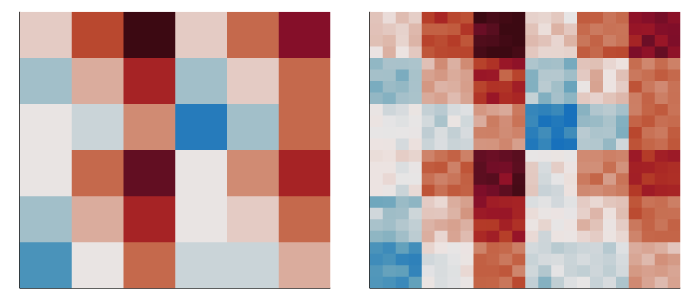

In [474]:
n = 24; d = 24; s = Int(n/6); srand(1);
theta = ([1;3;5;0;3;6] .+ [0;4;8;0;3;6]' - 5) * 2
theta[1,4] = theta[1,5]; theta[2,4] = theta[3,4]; theta[4,1] = theta[3,1];
theta[4,6] = theta[5,6];
theta = repeat(theta, inner = (s,s))
y = theta + randn(n,d);
a = maximum(theta);
default(dpi = 400)
F1 = Plots.heatmap(theta, fillcolor = :balance, normalize = true, clim = (-a,a), legend = :none,
    ticks = false);
F2 = Plots.heatmap(y, fillcolor = :balance, normalize = true, clim = (-a,a), legend = :none,
                    ticks = false);
Plots.plot(F1, F2, size = (700,300))

In [456]:
g1 = PathGraph(n); g2 = PathGraph(d);
D1 = -incidence_matrix(g1, oriented = true)';
D2 = -incidence_matrix(g2, oriented = true)';
G1 = cartesian_product(g1,g2);

In [427]:
function BGSM_cartesian(y, D1, D2;
                        init = y, v0 = 1e-1, v1 = 1e6,
                        c = 0.1, convtol = 1e-14,  
                        iter = 100)
                            
    
    # get size
    n1,n2 = size(y); n = n1 * n2;
    
    # initialize
    theta = copy(y);
    q1 = zeros(size(D1,1)); q2 = zeros(size(D2,1));
    sigmasq1 = 1; sigmasq2 = c;
    m = mean(y);
    
    # loop start
    for i = 1:iter
        
        # save previous iteration
        q1_old = copy(q1);
        q2_old = copy(q2);
        
        # E-step: update g1
        d1 = sum((D1 * theta).^2,2);
        q1 = 1./( 1 + sqrt(v0/v1) .* exp.(d1/2 * (1/v0 - 1/v1)/sigmasq1/n2) );
        t1 = q1/v0 + (1-q1)/v1;
        
        # E-step: update g2
        d2 = sum((D2 * theta').^2,2);
        q2 = 1./( 1 + sqrt(v0/v1) .* exp.(d2/2 * (1/v0 - 1/v1)/sigmasq2/n1) );
        t2 = q2/v0 + (1-q2)/v1;
        
        # M-step: update theta
        L1 = D1' * Diagonal(t1[:]) * D1;
        L2 = D2' * Diagonal(t2[:]) * D2;
        L = kron(L2, speye(n1)) + kron(speye(n2),L1);
        
        theta = reshape((speye(n) + L)\y[:], n1, n2);
        
        
        if (norm(q1 - q1_old) + norm(q2 - q2_old) < convtol)
            break;
        end
        
    end
    
    Q1 = find(q1 .> 0.5);
    Q2 = find(q2 .> 0.5);
    
    return Dict([
                (:theta, theta), (:q1, q1), (:q2, q2)
                ])
end

BGSM_cartesian (generic function with 2 methods)

In [428]:
function BGSM_cartesian_biclust(y;
                                ind1 = 1:size(y,1),
                                ind2 = 1:size(y,2),
                                init = y,
                                v0 = 1e-1,
                                convtol = 1e-14,  
                                iter = 100,
                                verbose = true)
                            
    
    # get size
    n1,n2 = size(y); n = n1 * n2;
    
    
    # initialize
    theta = copy(y);
    k1 = length(ind1); k2 = length(ind2);
    mu1 = copy(y[ind1,:]); mu2 = copy(y[:,ind2]);
    q1 = zeros(n1,k1); q2 = zeros(n2,k2);
    sigmasq1 = 1; sigmasq2 = 1;
    
    # loop start
    for i = 1:iter
        
        # save previous iteration
        q1_old = copy(q1);
        q2_old = copy(q2);
        
        # E-step: update g1
        d1 = reshape(sum((repmat(theta,k1,1) - kron(mu1,ones(n1))).^2,2),n1,k1);
        q1 = exp.(-d1/(2*n2*v0)); q1 = q1 ./ sum(q1,2);
        
        # E-step: update g2
        d2 = reshape(sum((repmat(theta',k2,1) - kron(mu2',ones(n2))).^2,2),n2,k2);
        q2 = exp.(-d2/(2*n1*v0)); q2 = q2 ./ sum(q2,2);
        
        # M-step: update theta
        L1 = (speye(n1) - (q1 ./ sum(q1,1)) * q1')/v0;
        L2 = (speye(n2) - (q2 ./ sum(q2,1)) * q2')/v0;
        L = kron(L2, speye(n1)) + kron(speye(n2),L1);
        theta = reshape((speye(n) + L)\y[:], n1,n2);
        mu1 = (q1 ./ sum(q1,1))' * theta;
        mu2 = theta * (q2 ./ sum(q2,1));
        
        if verbose & (rem(i,5) == 0)
            @printf "%3d-th iteration done: error = %0.2e\n" i norm(q1 - q1_old) + norm(q2 - q2_old)
        end
        
        if verbose & (norm(q1 - q1_old) + norm(q2 - q2_old) < convtol)
            @printf "the algorithm converged at %3d-th iteration: error = %0.2e\n" i norm(q1 - q1_old) + norm(q2 - q2_old)
            break;
        end
        
    end
    
    Q1    = copy(q1); Q2 = copy(q2);
    Q1[Q1 .< 1e-1] = 0; Q2[Q2 .< 1e-1] = 0;
    Q1    = Q1 ./ sum(Q1, 2);
    Q2    = Q2 ./ sum(Q2, 2);
    final = ((Q1 ./ sum(Q1,1)) * Q1') * theta * ((Q2 ./ sum(Q2,1)) * Q2')
    
    return Dict([
                (:theta, theta), (:q1, q1), (:q2, q2), (:mu1, mu1), (:mu2, mu2), (:final, final),
                (:Q1, Q1), (:Q2, Q2)
                ])
end

BGSM_cartesian_biclust (generic function with 1 method)

In [471]:
out = BGSM_cartesian(y, D1, D2, v0 = 1e-1 * 3, v1 = 1e4, iter = 500, c = 1);
out[:final] = copy(out[:theta])
for i = 1:6
    for j = 1:6
        out[:final][i*4-3:i*4,j*4-3:j*4] = mean(out[:theta][i*4-3:i*4,j*4-3:j*4])
    end
end
out1 = BGSM_cartesian_biclust(y, v0 = 1e-1 *3, iter = 500, verbose = false);

In [483]:
F1 = Plots.heatmap(theta, fillcolor = :balance, normalize = true, clim = (-a,a), legend = :none,
    ticks = false, title = "true theta");
F3 = heatmap(out[:final], fillcolor = :balance, clim = (-a,a), legend = false, ticks = false,
            title = "bi-changepoint (mse = 0.134)")
F4 = heatmap(out1[:final], fillcolor = :balance, clim = (-a,a), ticks = false,
            title = "bi-clustering (mse = 0.342)" )
Plots.plot(F1,F3,F4, size = (1500,500), layout = grid(1,3,widths=[0.3,0.3,0.4]))
Plots.savefig("figure/fig_change_vs_clust")